
Iniciando análise para: Sinal


Processando Sinal:   0%|          | 8/100000 [00:00<21:30, 77.45it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Processando Sinal: 100%|██████████| 100000/100000 [25:11<00:00, 66.18it/s]



Iniciando análise para: ZZ


Processando ZZ:  75%|███████▍  | 74951/100000 [17:34<05:52, 71.09it/s]ERROR::ReaderAsciiHepMC2: HEPMC3_ERROR parsing particle information
ERROR::ReaderAsciiHepMC2: event parsing failed. Returning empty event



DEBUG(1)::Parsing failed at line:
P 4218 221 -1.3387562975612219e+

Iniciando análise para: JJmumu


Processando JJmumu:  79%|███████▉  | 79221/100000 [18:19<04:48, 72.06it/s]ERROR::ReaderAsciiHepMC2: HEPMC3_ERROR parsing particle information
ERROR::ReaderAsciiHepMC2: event parsing failed. Returning empty event



DEBUG(1)::Parsing failed at line:
P 2414 211 -1.9511519670023364e-01 -3.1322666161810855e-02 2.9672035445183886e+00 2.9770501690266058e+00 1.395700000000000

Iniciando análise para: TT


Processando TT: 100%|██████████| 100000/100000 [24:27<00:00, 68.13it/s]



Iniciando análise para: JJ


Processando JJ: 100%|██████████| 100000/100000 [21:01<00:00, 79.30it/s]



Iniciando análise para: ZJJ_2b


Processando ZJJ_2b:  87%|████████▋ | 87048/100000 [20:56<03:06, 69.30it/s]ERROR::ReaderAsciiHepMC2: HEPMC3_ERROR parsing particle information
ERROR::ReaderAsciiHepMC2: event parsing failed. Returning empty event



DEBUG(1)::Parsing failed at line:
P 4193 -211 4.315245

Iniciando análise para: ZJJ_2mu


Processando ZJJ_2mu: 100%|██████████| 100000/100000 [23:08<00:00, 72.04it/s]



Iniciando análise para: HJJ_2mu


Processando HJJ_2mu: 100%|██████████| 100000/100000 [22:36<00:00, 73.70it/s]



Cutflow final:

               Total                    Muon Pair                Muon Mass (100-150)      ≥2 Jets (pT>30, |η|<4.5) Dijet Mass (90-160)      ≥2 b-jets (nos 2 líderes)
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Sinal          100000                   64473                    61251                    54957                    13620                    13540                    
ZZ             74951                    38869                    164                      131                      13                       13                       
JJmumu         79221                    55807                    2270                     1377                     336                      316                      
TT             100000                   1369                     232                      230                      58                       56           

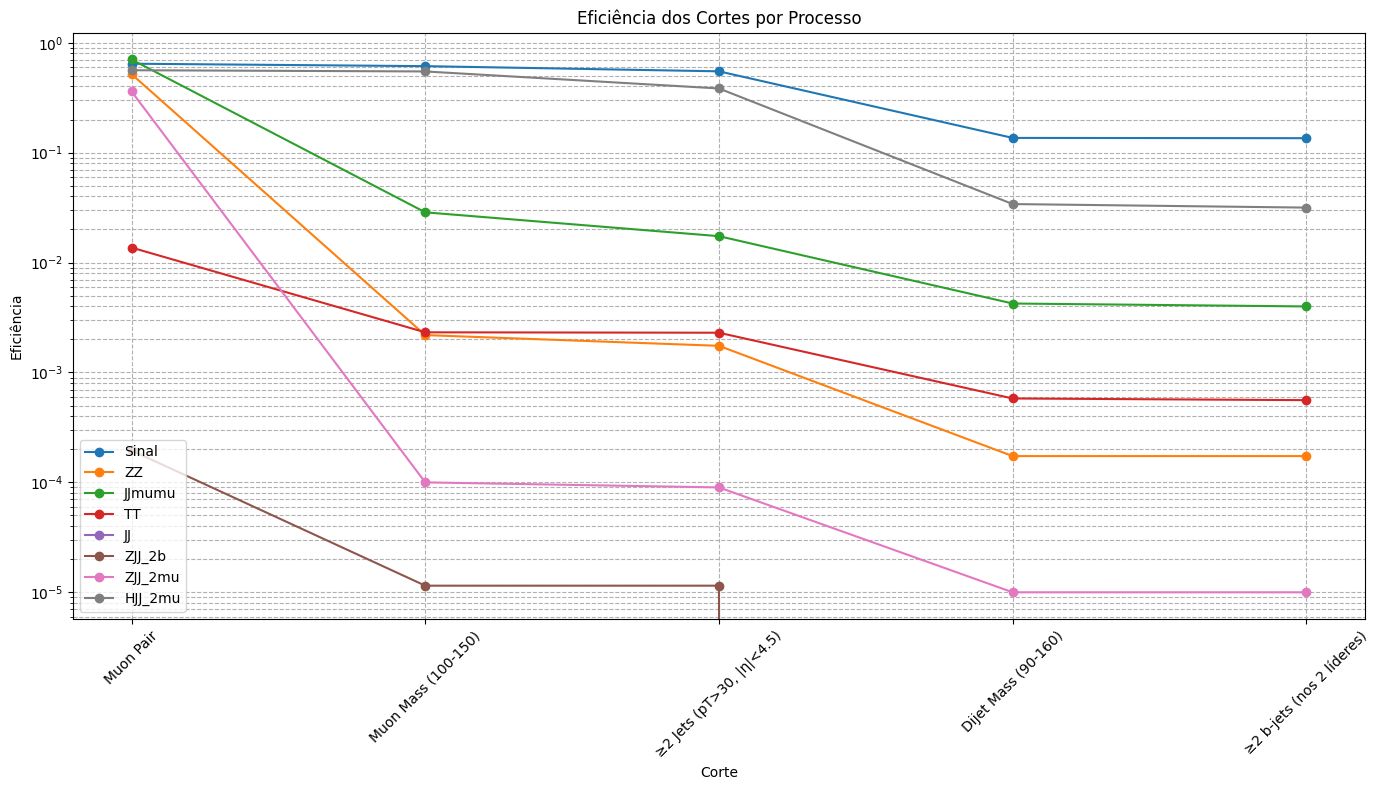

In [2]:
import pyhepmc as hep
import numpy as np
import pandas as pd
import fastjet as fj
import psutil
import os
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configurações de memória e processamento
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

max_events = 100000
chunk_size = 100000

# Arquivos de entrada
files = {
    "Sinal": "/home/lphelipe/Resultados/v2/pp_hh_10x_100TeV.hepmc",
    "ZZ": "/home/lphelipe/Resultados/novos/zz_10x_100TeV.hepmc",
    "JJmumu": "/home/lphelipe/Resultados/v2/jjmumu_10x_100TeV_v2.hepmc",
    "TT": "/home/lphelipe/Resultados/v2/tt_10x_100TeV_v2.hepmc",
    "JJ": "/home/lphelipe/Resultados/novos/jj_10x_100TeV.hepmc",
    "ZJJ_2b": "/home/lphelipe/Resultados/v2/pp_zjj_2b.hepmc",
    "ZJJ_2mu": "/home/lphelipe/Resultados/v2/pp_zjj_2mu.hepmc",
    "HJJ_2mu": "/home/lphelipe/Resultados/v2/pp_hjj_2mu.hepmc"
}

# Luminosidade do FCC-hh [fb^-1] (20000 fb^-1 = 20 ab^-1)
TARGET_LUMINOSITY = 20000.0  

# Funções de física
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        mean_displacement = np.mean(secondary_vertex_displacement)
        return mean_displacement > 1.0, mean_displacement
    return False, 0.0

def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]

def find_opposite_charge_muons(particles):
    # Filtra múons que passam os cortes básicos
    muons = [p for p in particles if abs(p.pid) == 13 and p.momentum.pt() > 20.0 and abs(p.momentum.eta()) < 2.5]
    
    # Ordena todos os múons por pT (do maior para o menor)
    muons_sorted = sorted(muons, key=lambda m: m.momentum.pt(), reverse=True)
    
    pairs = []
    used_indices = set()
    
    # Forma pares com cargas opostas
    for i in range(len(muons_sorted)):
        if i in used_indices:
            continue
        for j in range(i + 1, len(muons_sorted)):
            if j in used_indices:
                continue
            if muons_sorted[i].pid == -muons_sorted[j].pid:
                pairs.append((muons_sorted[i], muons_sorted[j]))
                used_indices.add(i)
                used_indices.add(j)
                break  # Pega apenas o próximo múon com carga oposta
    
    return pairs

def delta_r(jet1, jet2):
    dphi = jet1.phi() - jet2.phi()
    deta = jet1.eta() - jet2.eta()
    return np.sqrt(dphi**2 + deta**2)

def analyze_hepmc_file(filename, label, max_events=max_events):
    # Definir a ordem dos cortes explicitamente
    cutflow_steps = [
        "Total",
        "Muon Pair",
        "Muon Mass (100-150)",
        "≥2 Jets (pT>30, |η|<4.5)",
        "Dijet Mass (90-160)",
        "≥2 b-jets (nos 2 líderes)"
    ]
    
    # Inicializa o cutflow com a ordem correta
    cutflow = {step: 0 for step in cutflow_steps}
    
    results = []
    
    with hep.open(filename) as f:
        for i, event in enumerate(tqdm(f, desc=f"Processando {label}", total=max_events)):
            if i >= max_events:
                break
                
            cutflow["Total"] += 1
            
            # Partículas estáveis com pT > 2 GeV
            particles = [p for p in event.particles if p.status == 1 and p.momentum.pt() > 2.0]
            
            # 1. Corte: Pares de múons com cargas opostas (apenas os dois de maior pT)
            muon_pairs = find_opposite_charge_muons(particles)
            if not muon_pairs:
                continue
            cutflow["Muon Pair"] += 1
            
            # Pegar APENAS o PRIMEIRO par (já ordenado por pT)
            muon1 = fj.PseudoJet(muon_pairs[0][0].momentum.x, muon_pairs[0][0].momentum.y, 
                                muon_pairs[0][0].momentum.z, muon_pairs[0][0].momentum.e)
            muon2 = fj.PseudoJet(muon_pairs[0][1].momentum.x, muon_pairs[0][1].momentum.y, 
                                muon_pairs[0][1].momentum.z, muon_pairs[0][1].momentum.e)
            
            # 2. Corte: Massa invariante dos múons (100-150 GeV)
            inv_mass = invariant_mass(muon1, muon2)
            if not (100 < inv_mass < 150):
                continue
            cutflow["Muon Mass (100-150)"] += 1
            
            # Remover múons e clusterizar jatos
            particles_no_muons = remove_muons(particles)
            fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) 
                          for p in particles_no_muons]
            
            jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
            cluster_seq = fj.ClusterSequence(fj_particles, jet_def)
            jets = [j for j in cluster_seq.inclusive_jets(30.0) if abs(j.eta()) < 4.5]
            
            # 3. Corte: ≥2 jatos com pT > 30 GeV e |η| < 4.5
            if len(jets) < 2:
                continue
            cutflow["≥2 Jets (pT>30, |η|<4.5)"] += 1
            
            # Ordenar jatos por pT (decrescente)
            jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)
            jet1, jet2 = jets_sorted[0], jets_sorted[1]
            
            # 4. Corte: Massa invariante dos dijets (90-160 GeV) - SEMPRE com os 2 jatos líderes
            dijet_mass = invariant_mass(jet1, jet2)
            if not (90 <= dijet_mass <= 160):
                continue
            cutflow["Dijet Mass (90-160)"] += 1
            
            # Verificar b-tagging apenas para os dois jatos líderes em pT
            is_b_tagged1, b_tag_distance1 = is_b_tagged(jet1, particles_no_muons)
            is_b_tagged2, b_tag_distance2 = is_b_tagged(jet2, particles_no_muons)
            
            # 5. Corte: ≥2 b-jets (entre os dois jatos líderes)
            if not (is_b_tagged1 and is_b_tagged2):  # Ambos devem ser b-jets
                continue
            cutflow["≥2 b-jets (nos 2 líderes)"] += 1
            
            # Salva resultados
            results.append({
                'muon_mass': inv_mass,
                'muon1_pt': muon1.pt(),
                'muon2_pt': muon2.pt(),
                'dijet_mass': dijet_mass,
                'jet1_pt': jet1.pt(),
                'jet2_pt': jet2.pt(),
                'jet1_is_b_tagged': is_b_tagged1,
                'jet2_is_b_tagged': is_b_tagged2,
                'b_tag_distance1': b_tag_distance1,
                'b_tag_distance2': b_tag_distance2,
                'weight': event.weights[-1] if event.weights else 1.0,
                'label': label
            })
            
            # Gerenciamento de memória
            if i % chunk_size == 0:
                gc.collect()
                print_memory_usage()
    
    return pd.DataFrame(results), cutflow
# Processamento principal com cutflow
all_results = []
cutflows = {}

for label, filename in files.items():
    print(f"\nIniciando análise para: {label}")
    df, cutflow = analyze_hepmc_file(filename, label)
    all_results.append(df)
    cutflows[label] = cutflow

# Imprime o cutflow como tabela formatada
print("\nCutflow final:\n")

# Definir a ordem dos cortes (usando a ordem do primeiro cutflow como referência)
first_cutflow = next(iter(cutflows.values()))
cutflow_steps = list(first_cutflow.keys())

# Cabeçalho da tabela
header = f"{'':<15}" + "".join([f"{step:<25}" for step in cutflow_steps])
print(header)
print("-" * len(header))

# Linhas para cada processo
for label, cutflow in cutflows.items():
    row = f"{label:<15}"
    for step in cutflow_steps:
        row += f"{cutflow.get(step, 'N/A'):<25}"
    print(row)

# Salva resultados
final_df = pd.concat(all_results)
output_dir = "cutflow"
os.makedirs(output_dir, exist_ok=True)

signal_df = final_df[final_df['label'] == "Sinal"]
background_df = final_df[final_df['label'] != "Sinal"]

signal_df.to_csv(os.path.join(output_dir, "signal_cutflow_v6.csv"), index=False)
background_df.to_csv(os.path.join(output_dir, "background_cutflow_v6.csv"), index=False)
final_df.to_csv(os.path.join(output_dir, "all_events_cutflow_v6.csv"), index=False)

# Plot do cutflow
plt.figure(figsize=(14, 8))
for label, cutflow in cutflows.items():
    steps = list(cutflow.keys())[1:]  # Remove "Total"
    values = [cutflow[step]/cutflow['Total'] for step in steps]
    plt.plot(steps, values, 'o-', label=label)

plt.title("Eficiência dos Cortes por Processo")
plt.xlabel("Corte")
plt.ylabel("Eficiência")
plt.xticks(rotation=45)
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.savefig("cutflow_efficiency_v6.png")
plt.show()